In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pyccl as ccl
import os.path 
import math
from os.path import exists as file_exists
import emcee
from scipy.optimize import minimize
from getdist import plots, MCSamples
import getdist
import corner
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import RegularGridInterpolator

In [2]:
choose_file = []
for i in range(0,6):
    for j in range(0,12):
        for filename in os.listdir('/mnt/zfsusers/anyabua/FermiX'):
            if filename == "W_galagam_" + str(i)+"x"+str(j)+".npz":
                choose_file.append(str(filename))
data_files = np.reshape(choose_file,(6,12))

ells = np.load(data_files[0][0])['ells']
all_jackerrors = np.array([[np.squeeze(np.load(data_files[gal][gam])['jack_error']) for gam in range(12)] for gal in range(6)]) 
all_pcl = np.array([[np.squeeze(np.load(data_files[gal][gam])['PCL_fskydivided']) for gam in range(12)] for gal in range(6)])
all_bpw = np.array([[np.load(data_files[gal][gam])['bpw'] for gam in range(12)] for gal in range(6)])
all_JKCL = np.array([[np.load(data_files[gal][gam])['JKCL'] for gam in range(12)] for gal in range(6)])

In [3]:
z = {}
dndz = {}
for gal in range(6):
    z[f'{gal}'], dndz[f'{gal}'] = np.loadtxt(f"dndz_bin{gal}.txt", unpack=True)

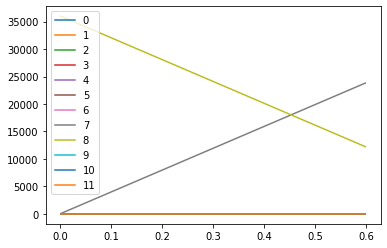

In [4]:
Edges = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
 5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
 3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
 1.00000000e+06])

def heaviside(x,y):
    return 1*(x>y)

z_4test = np.ones((150))

redshifted1 = np.zeros((13,150))
for i in range(13):
    redshifted1[i] = Edges[i]/(1+z['3']) #z_4test #


#redshifted is now an array of an array of redshifted energies, where the dimension of 
#the array within the array is equal to the 13xdim(z) where 13 corresponds to the 13 energy edges. 



windows = []

for n in range(12):
    for i in range(12):
        for k in range(150):
            w = (min(Edges[i+1],redshifted1[n+1,k])-
                 max(Edges[i],redshifted1[n,k]))*heaviside(redshifted1[n+1,k],Edges[i])*heaviside(Edges[i+1],redshifted1[n,k])   #/(Edges[i+1]-Edges[i])
            windows.append(w)
    
windows = np.reshape(windows,(12,12,150))*(1+z['3'][None, None, :])

for i, w in enumerate(windows[8]):
    plt.plot(z['3'], w, label=f'{i}')
plt.legend()


In [5]:
from scipy.special import sici

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96) #need to make a K(z) function
k_arr = np.geomspace(1E-4,100,256)
a = 1./(1+z['3']) 
a_arr = a[::-1]
chi = ccl.comoving_radial_distance(cosmo,a_arr)[::-1]


# We will use a mass definition with Delta = 200 times the matter density
hmd_200c = ccl.halos.MassDef200c() 

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200c)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.profiles.HaloProfileNFW(cM)

class DarkMatterAnnihilationProfile(ccl.halos.HaloProfile):
    def __init__(self,c_M_relation):
        self.cM = c_M_relation
        super().__init__()
        
    def _get_cM(self, cosmo, M, a, mdef=None):
        return self.cM.get_concentration(cosmo, M, a, mdef_other = mdef)
    
    def _fourier(self, cosmo, k , M , a , mass_def):
        rho_matter = cosmo.rho_x(1., "matter", is_comoving=True)
        M_use = np.atleast_1d(M)
        k_use = np.atleast_1d(k)
    
        
        R_M = mass_def.get_radius(cosmo, M_use, a) / a #comoving virial radius
        c_M =self._get_cM(cosmo,M_use,a,mass_def)
    
        R_s = R_M / c_M
        rho0 = M_use / (4 * np.pi * R_s**3*rho_matter**2)

        q = k_use[None, :] * R_s[:, None]
        
        
        Si_q, Ci_q = sici(q)
        P1 = M_use /((np.log(1 + c_M) - c_M/ (1 + c_M))**2)
        c_M = c_M[:, None]
        Si_oneplusc, Ci_oneplusc = sici((1 + c_M) * q)
        Si_qc, Ci_qc = sici(q*c_M)
        
        A = (rho0 * P1)[:, None] / q
        
        Si1 = Si_oneplusc - Si_q
        Ci1 = Ci_oneplusc - Ci_q
        
        q_half = (1-(q**2)/2)
        q_sixth = (q-(q**3)/6)
        
        Si_term = Si1*(q_half*np.cos(q)+ q_sixth*np.sin(q))
        Ci_term = Ci1*(q_half*np.sin(q)-q_sixth*np.cos(q))
        
        sin_term = np.sin(q*c_M)*((6*(1 + c_M)**2 + 5 + 3*c_M - (q**2)*(1+c_M)**2)/(6*(1 + c_M)**3))
        cos_term = q*np.cos(q*c_M)*(4 + 3*c_M)/(6*(1 + c_M)**2)
      
        prof = A*(Si_qc - Si_term + Ci_term - 2*q/3 + sin_term + cos_term)
     
        
        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
    
        return prof
        
                           

pDM = DarkMatterAnnihilationProfile(cM)


hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200c)
pk_DMxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pDM, prof2= pM,
                                  normprof1=True, normprof2=True,
                                  lk_arr=np.log(k_arr), a_arr=a_arr)
pk_MxMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pM, prof2=pM,
                                 normprof1=True, normprof2=True,
                                 lk_arr=np.log(k_arr), a_arr=a_arr)


# Point Spread Function

['theta_deg', 'psf', 'psf_mean', 'ell', 'bl', 'bl_mean']
(128,) (4, 13, 128) (13, 128) (99,) (4, 13, 99) (13, 99)
(12, 24)


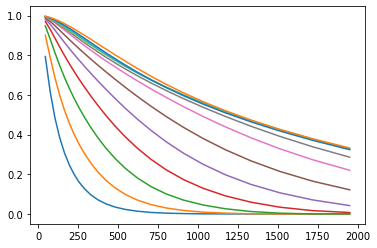

In [6]:
FermiBeam = np.load('psf_Fermi.npz')
print(FermiBeam.files)

theta_deg = FermiBeam['theta_deg']
psf = FermiBeam['psf']
psf_mean = FermiBeam['psf_mean']
ell = FermiBeam['ell']
bl = FermiBeam['bl']
bl_mean = FermiBeam['bl_mean']

print(theta_deg.shape, psf.shape, psf_mean.shape, ell.shape, bl.shape, bl_mean.shape)

E = np.exp(0.5*(np.log(Edges[1:])+np.log(Edges[:-1])))

interp = RegularGridInterpolator((Edges , ell) , bl_mean)

interp2 = RegularGridInterpolator((Edges, theta_deg), psf_mean)

b_interp = np.zeros((12,24))
psf_interp = np.zeros((12,128))
for i in range(12):
    for j in range(24):
        b_interp[i,j] = interp([E[i],ells[j]])
        
for i in range(12):
    for j in range(128):
        psf_interp[i,j] = interp2([E[i],theta_deg[j]])
        
for i in range(12):
    plt.plot(ells,b_interp[i])

print(b_interp.shape)





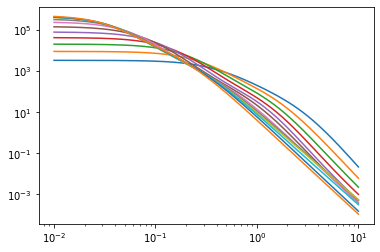

In [7]:
for i in range(12):
    plt.plot(theta_deg, psf_interp[i])
    plt.loglog()

In [8]:
bias = np.array([1.182,1.086,1.126,1.144,1.206,1.548])

rho_x = ccl.background.rho_x(cosmo,1,'matter',is_comoving = True)

clight = 3e8
C = ((rho_x*clight**2)*(1+z['3']))**2/(8*np.pi)

print(z['4'])
################ GALAXY TRACER ###############################

t_g = []
for gal in range(6):
    t_gal = ccl.NumberCountsTracer(cosmo, has_rsd = False, dndz=(z[f'{gal}'],dndz[f'{gal}']), 
                                   bias=(z[f'{gal}'], np.ones_like(z[f'{gal}'])))
    t_g.append(t_gal)
    
galtracer = np.array(t_g)


######### GRB TRACER ########################################


cl_th_PSF = np.zeros([6, 12, 12, 24])
cl_th_noPSF = np.zeros([6, 12, 12, 24])
for ig, g in enumerate(galtracer):
    for i in range(12):
        for j in range(12):
            GRB_tracer = ccl.Tracer()
            GRB_tracer.add_tracer(cosmo, kernel=(chi, C*windows[i, j]))
            cl_theoretical = ccl.angular_cl(cosmo, g, GRB_tracer, ells, p_of_k_a=pk_DMxMf)
            cl_th_PSF[ig,i,j] = cl_theoretical*b_interp[j]
            cl_th_noPSF[ig, i, j, :] = cl_theoretical            
            
            
#cl[ig,i,j,:] = cl_theoretical 
#ig - gal index
#i - index n in overleaf (corresponding to sum with F)
#j - index i in overleaf (corresponding to index i for energy)
#ordering is this way due to how i constructed windows array


[0.002 0.006 0.01  0.014 0.018 0.022 0.026 0.03  0.034 0.038 0.042 0.046
 0.05  0.054 0.058 0.062 0.066 0.07  0.074 0.078 0.082 0.086 0.09  0.094
 0.098 0.102 0.106 0.11  0.114 0.118 0.122 0.126 0.13  0.134 0.138 0.142
 0.146 0.15  0.154 0.158 0.162 0.166 0.17  0.174 0.178 0.182 0.186 0.19
 0.194 0.198 0.202 0.206 0.21  0.214 0.218 0.222 0.226 0.23  0.234 0.238
 0.242 0.246 0.25  0.254 0.258 0.262 0.266 0.27  0.274 0.278 0.282 0.286
 0.29  0.294 0.298 0.302 0.306 0.31  0.314 0.318 0.322 0.326 0.33  0.334
 0.338 0.342 0.346 0.35  0.354 0.358 0.362 0.366 0.37  0.374 0.378 0.382
 0.386 0.39  0.394 0.398 0.402 0.406 0.41  0.414 0.418 0.422 0.426 0.43
 0.434 0.438 0.442 0.446 0.45  0.454 0.458 0.462 0.466 0.47  0.474 0.478
 0.482 0.486 0.49  0.494 0.498 0.502 0.506 0.51  0.514 0.518 0.522 0.526
 0.53  0.534 0.538 0.542 0.546 0.55  0.554 0.558 0.562 0.566 0.57  0.574
 0.578 0.582 0.586 0.59  0.594 0.598]


In [9]:
A_matrix_PSF = np.zeros((6, 12, 12))
A_matrix_noPSF = np.zeros((6, 12, 12))
for g in range(6):
    for n in range(12):
        for m in range(12):
            A_matrix_PSF[g, n, m] = np.sum(cl_th_PSF[g,n,:,:]*cl_th_PSF[g,m,:,:]/(all_jackerrors[g, :, :]**2)) 
            A_matrix_noPSF[g, n, m] = np.sum(cl_th_noPSF[g,n,:,:]*cl_th_noPSF[g,m,:,:]/(all_jackerrors[g, :, :]**2))

            
            
            
def check_posdef(x):
    return np.all(np.linalg.eigvals(x) > 0)




b_PSF = np.zeros((6,12))
b_noPSF = np.zeros((6,12))
for g in range(6):
    for n in range(12):
        b_PSF[g,n] = np.sum(cl_th_PSF[g,n,:,:]*all_pcl[g,:,:]/(all_jackerrors[g,:,:]**2))
        b_noPSF[g,n] = np.sum(cl_th_noPSF[g,n,:,:]*all_pcl[g,:,:]/(all_jackerrors[g,:,:]**2))
#print(b[1])

F_PSF = np.zeros((6,12))
F_noPSF = np.zeros((6,12))
for g in range(6):
    F_PSF[g] = np.linalg.solve(A_matrix_PSF[g],b_PSF[g])
    F_noPSF[g] = np.linalg.solve(A_matrix_noPSF[g], b_noPSF[g])
    
    
bestcl_PSF = np.zeros((6,12,24))
bestcl_noPSF = np.zeros((6,12,24))
for g in range(6):
    for i in range(12):
        for el in range(24):
            bestcl_PSF[g,i,el] = np.sum(F_PSF[g,:]*cl_th_PSF[g,:,i,el])
            bestcl_noPSF[g,i,el] = np.sum(F_noPSF[g,:]*cl_th_noPSF[g,:,i,el])
            
            
fileiscalled = 'best_cl_values.npz'
np.savez(fileiscalled, bestcl_PSF = bestcl_PSF , bestcl_noPSF = bestcl_noPSF)


In [10]:
b_comb_PSF = np.sum(b_PSF, axis = 0)
A_comb_PSF = np.sum(A_matrix_PSF, axis = 0)
F_comb_PSF = np.linalg.solve(A_comb_PSF,b_comb_PSF)
F_cov2_PSF = np.linalg.inv(A_comb_PSF)
cov_F_PSF = np.linalg.inv(A_matrix_PSF)

cfac = 1.81493167e39

print(b_PSF.shape)
print(A_matrix_PSF.shape)

b_comb_noPSF = np.sum(b_noPSF, axis = 0)
A_comb_noPSF = np.sum(A_matrix_noPSF, axis = 0)
F_comb_noPSF = np.linalg.solve(A_comb_noPSF,b_comb_noPSF)
F_cov2_noPSF = np.linalg.inv(A_comb_noPSF)
cov_F_noPSF  = np.linalg.inv(A_matrix_noPSF)


(6, 12)
(6, 12, 12)


Text(0.5, 1.0, 'Annihilation')

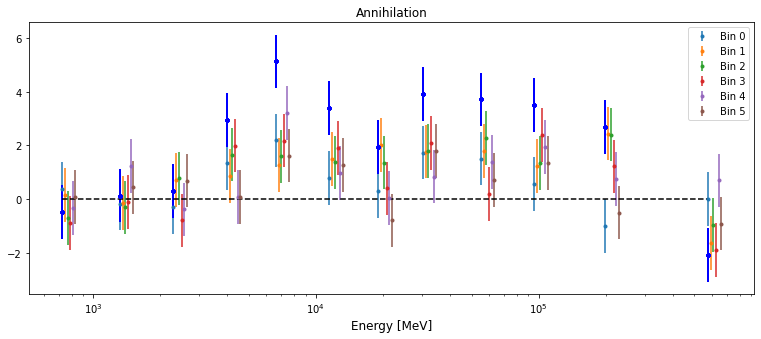

In [11]:
#E_mean = np.exp(0.5*(np.log(Edges[1:])+np.log(Edges[:-1])))
f = plt.figure()
#print(E_mean)


geomE_mean = np.sqrt(np.array(Edges[1:])*np.array(Edges[:-1]))


for i in range(6):
    plt.errorbar(E*(1+0.03*i), F_noPSF[i]/np.sqrt(np.diag(cov_F_noPSF[i])), yerr=np.ones(12), fmt='.', label=f'Bin {i}')

    
for i in range(12):
    plt.errorbar(E, F_comb_noPSF/np.sqrt(np.diag(F_cov2_noPSF)), yerr=np.ones(12), fmt='b.')

plt.xscale('log')
plt.legend()
plt.plot(E, np.zeros(12), 'k--')

f.set_figwidth(13)
f.set_figheight(5)
plt.xlabel('Energy [MeV]',fontsize = 12)
plt.title('Annihilation')


# F-Plots 

Text(0.5, 0, 'Energy $[{\\rm MeV}]$')

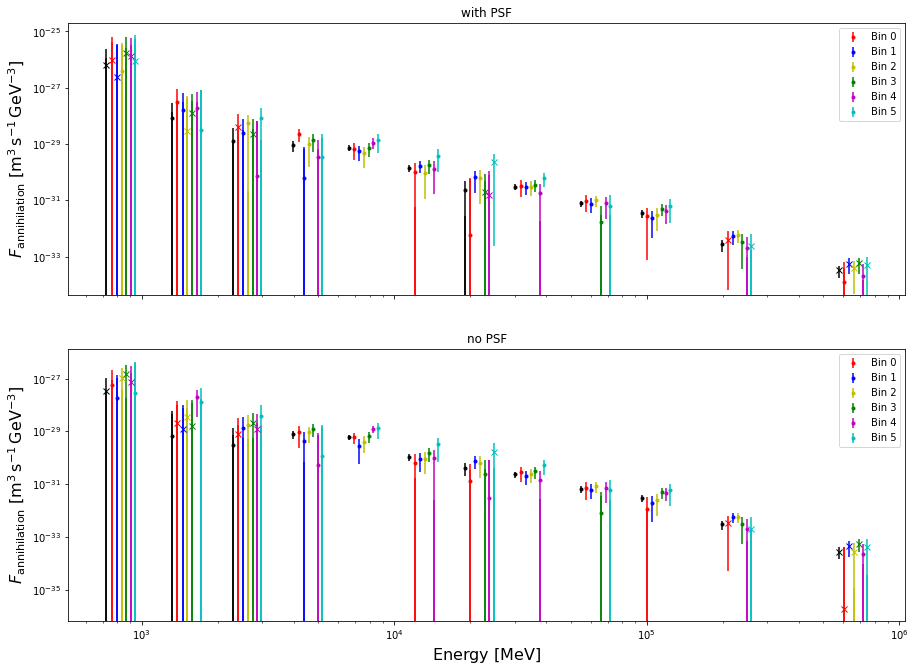

In [12]:
fig, ax = plt.subplots(2,figsize=(15, 11), sharex = True)

for g, c in enumerate(['r', 'b', 'y', 'g', 'm', 'c']):
    ax[0].errorbar(E*(1+0.05*(g+1)), cfac*F_PSF[g], yerr=cfac*np.sqrt(np.diag(cov_F_PSF[g])), fmt=c+'.', label=f'Bin {g}')
    ax[0].errorbar(E*(1+0.05*(g+1)), -cfac*F_PSF[g], yerr=cfac*np.sqrt(np.diag(cov_F_PSF[g])), fmt=c+'x')
    ax[1].errorbar(E*(1+0.05*(g+1)), cfac*F_noPSF[g], yerr=cfac*np.sqrt(np.diag(cov_F_noPSF[g])), fmt=c+'.', label=f'Bin {g}')
    ax[1].errorbar(E*(1+0.05*(g+1)), -cfac*F_noPSF[g], yerr=cfac*np.sqrt(np.diag(cov_F_noPSF[g])), fmt=c+'x')
    
ax[0].errorbar(E, cfac*F_comb_PSF, yerr=cfac*np.sqrt(np.diag(F_cov2_PSF)), fmt='k.')
ax[0].errorbar(E, -cfac*F_comb_PSF, yerr=cfac*np.sqrt(np.diag(F_cov2_PSF)), fmt='kx')
ax[1].errorbar(E, cfac*F_comb_noPSF, yerr=cfac*np.sqrt(np.diag(F_cov2_noPSF)), fmt='k.')
ax[1].errorbar(E, -cfac*F_comb_noPSF, yerr=cfac*np.sqrt(np.diag(F_cov2_noPSF)), fmt='kx')

titles = ['with PSF', 'no PSF']
ax[-1].set_xscale('log')
for i in range(2):
    axs = ax[i]
    axs.set_title(titles[i])
    axs.set_yscale('log')
    axs.legend()
    axs.set_ylabel(r'$F_{\rm annihilation}\,\,[{\rm m}^{3}\,{\rm s}^{-1}\,{\rm GeV}^{-3}]$', fontsize=16)
ax[-1].set_xlabel('Energy'+ ' '+ r'$[{\rm MeV}]$', fontsize = 16)

# MCMC for no PSF

In [13]:
MCMC_chains = np.load('MCMC_ann_chain.npz')
MCMC_chains.files

mcsamples_noPSF = MCMC_chains['mcsamples']
flat_samples_noPSF = MCMC_chains['flat_samples']


# MCMC with PSF

In [14]:
E = np.exp(0.5*(np.log(Edges[1:])+np.log(Edges[:-1])))

cfac = 1.81493167e39

F_ann = cfac*F_PSF
F_comb = cfac*F_comb_PSF
cov_F = cfac**2*cov_F_PSF
cov_Fcomb = cfac**2*F_cov2_PSF

inv_covF = np.linalg.inv(cov_F)
inv_covFcomb = np.linalg.inv(cov_Fcomb)

F = np.zeros((7,12))
F[0:6] = F_ann[0:6]
F[6] = F_comb

cinvF = np.zeros((7,12,12))
cinvF[0:6] = inv_covF[0:6]
cinvF[6] = inv_covFcomb

covFs = np.zeros((7,12,12))
covFs[0:6] = cov_F[0:6]
covFs[6] = cov_Fcomb




In [15]:
## defining functions for F


def power(E,a,F0):
    E0 = 2e4
    return 1e-30*F0*(E/E0)**a

def chi2(theta,E,F_ann,cinv):
    a, F0 = theta
    x = F_ann - power(E,a,F0)
    return -0.5*np.dot(x, np.dot(cinv, x))


def log_prior(theta):
    if (-3 < theta[0] < -1) & (0.001 < theta[1] < 3):
        return 0.0
    return -np.inf

def log_prob(theta,E,F_ann,cinv):
    lprior = log_prior(theta)
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + chi2(theta,E,F_ann,cinv)



In [16]:
nwalkers = 30
ndim = 2
niter = 5000
burn = 300

p0 = [[-2,0.3] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

mcsamples_PSF = np.zeros((7,ndim,nwalkers,niter-burn))
flat_samples_PSF = np.zeros((7,ndim,nwalkers*(niter-burn)))
for i in range(7):
    sampler = emcee.EnsembleSampler(nwalkers,ndim, lambda theta: log_prob(theta,E,F[i],cinvF[i]))
    pos,prob,state = sampler.run_mcmc(p0, niter, progress = True)
    mcsamples_PSF[i] = sampler.get_chain(discard = burn).T
    flat_samples_PSF[i] = sampler.get_chain(flat = True, discard = burn).T

100%|██████████| 5000/5000 [00:08<00:00, 597.16it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


<Figure size 576x576 with 0 Axes>

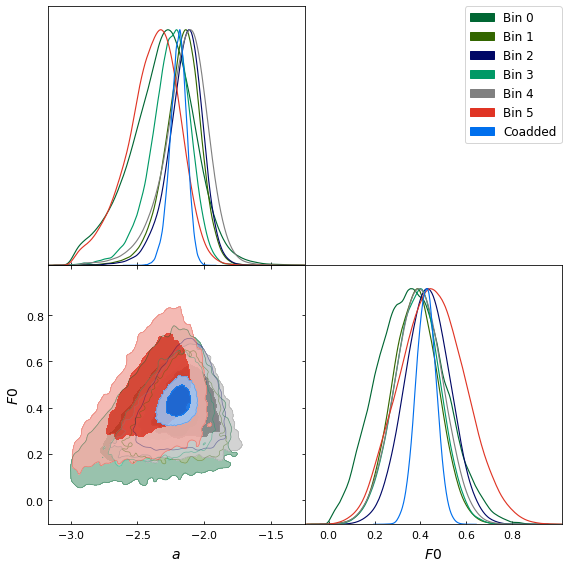

In [17]:
names = ['a_spectral', 'F0_proportional']
labels =  ['a', 'F0']
label = ['Bin 0','Bin 1','Bin 2','Bin 3','Bin 4','Bin 5', 'Coadded']
s = []
g = plots.get_single_plotter(ratio = 1, width_inch = 8 )
for i in range(7):
    #print(np.mean(flat_samples[i, 1])/np.std(flat_samples[i, 1]))
    samples_PSF = MCSamples(samples = flat_samples_PSF[i].T, names = names , labels = labels, label = label[i])
    s.append(samples_PSF)
g.triangle_plot(s, filled=True)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


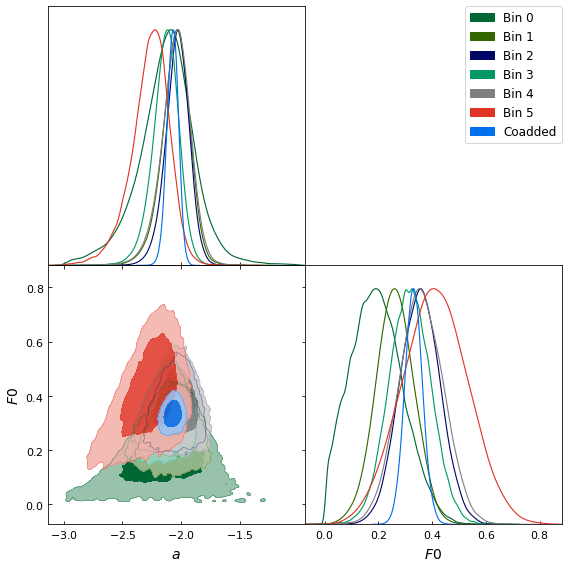

In [18]:
s2 = []
for i in range(7):
    samples_noPSF = MCSamples(samples = flat_samples_noPSF[i].T, names = names, labels = labels, label = label[i])
    s2.append(samples_noPSF)
g.triangle_plot(s2, filled=True)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


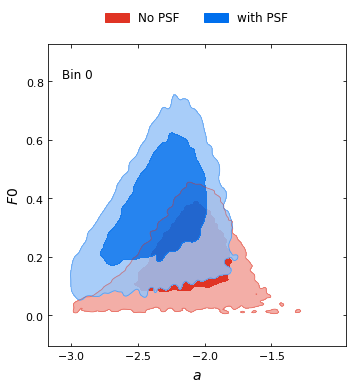

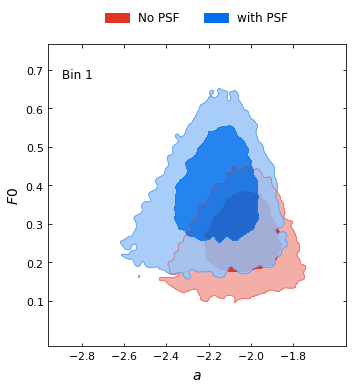

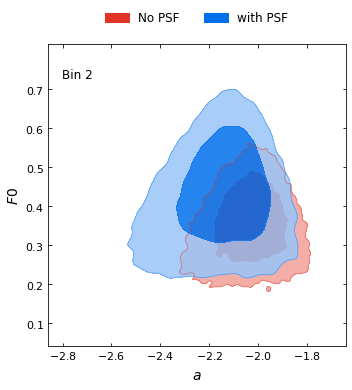

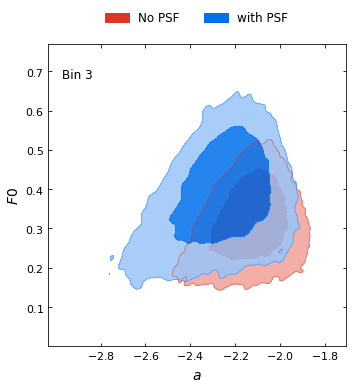

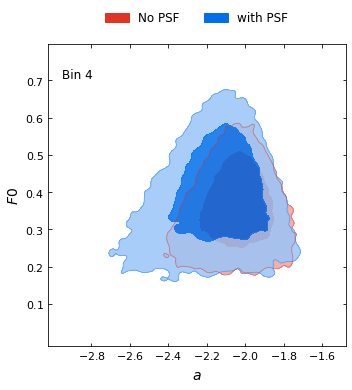

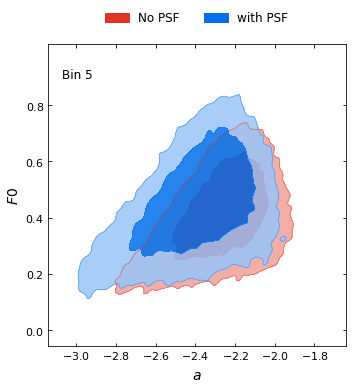

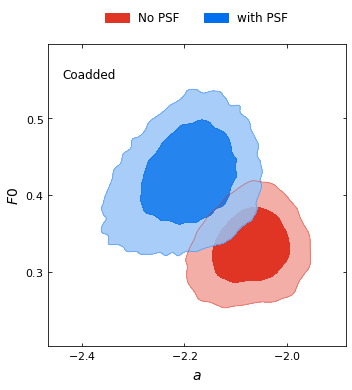

In [19]:
s4 = []
names2 = ['a', 'F0']
labels2 = ['No PSF', 'with PSF']
for i in range(7):
    samples_noPSF = MCSamples(samples = flat_samples_noPSF[i].T, names = names2, labels = labels, label = labels2[0])
    s4.append(samples_noPSF)
    samples_PSF = MCSamples(samples = flat_samples_PSF[i].T, names = names2 , labels = labels, label = labels2[1])
    s4.append(samples_PSF)

    p = samples_noPSF.getParams()
    p = samples_PSF.getParams()

    g = plots.get_subplot_plotter(subplot_size=5)
    g.settings.figure_legend_frame = False
    g.rectangle_plot(['a'], ['F0'], 
                     roots = [samples_noPSF,samples_PSF],plot_texts=[[label[i]]],
                     filled=True);